# Import Libraries

In [1]:

import os
from torchvision.transforms import Compose, Resize, InterpolationMode, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip
import torch
from code.classifier import ViTPneumoniaClassifier, Config
from code.plot_random_image import plot_random_image_from_loader
from code.classify_random_images import plot_random_images_with_labels
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt



C:\Users\aszab\miniconda3\envs\pneumonia_detection\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Load the TensorBoard
%reload_ext tensorboard
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
# Enable CUDA Launch Blocking
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# Set float32 matrix multiplication precision to 'medium' to utilize Tensor Cores
torch.set_float32_matmul_precision('medium')
torch.serialization.add_safe_globals([Compose, Resize, set, Config, InterpolationMode, ToTensor, Normalize, RandomHorizontalFlip])

# Check GPU Availability

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Sat Dec  7 21:41:23 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.90                 Driver Version: 565.90         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti   WDDM  |   00000000:02:00.0  On |                  N/A |
|  0%   45C    P8             13W /  285W |     714MiB /  12282MiB |      8%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Setup Model

In [5]:
config = Config(
    backbone_name="google/vit-base-patch16-224",
    transfer_learning=True,
    learning_rate=1e-5,
    batch_size=32,
    max_epochs=50,
    weight_decay=1e-5,
    dropout=0.3,
    num_workers=16,
    model_name="Vit_gradual_unfreeze",
    version="001",
    optimizer_name="adam",
    use_class_weights=True,
    image_res=224,
    patience=10,
    image_type=3,
    gradually_unfreeze=True,
    unfreeze_interval=5,
    num_layers_to_unfreeze=2,
    frozen_lr=1e-6,  # Learning rate for frozen layers
    unfrozen_lr=1e-5  # Learning rate for unfrozen layers
)


model = ViTPneumoniaClassifier(config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Plot random images from all datasets

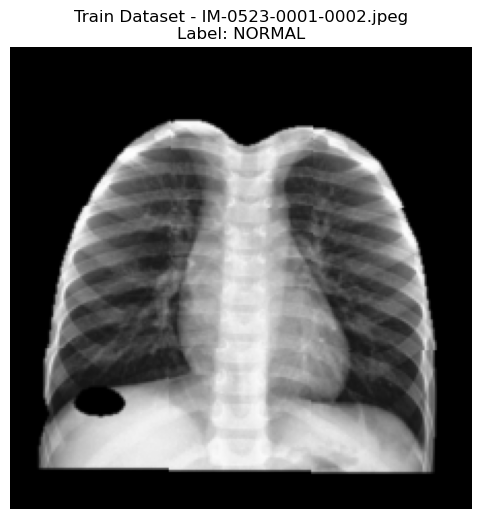

In [6]:
plot_random_image_from_loader(model.train_loader.dataset, "Train Dataset", normalize=False)

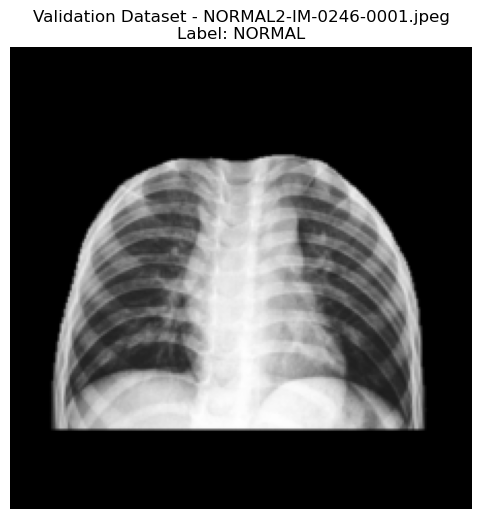

In [7]:
plot_random_image_from_loader(model.val_loader.dataset, "Validation Dataset", normalize=False)

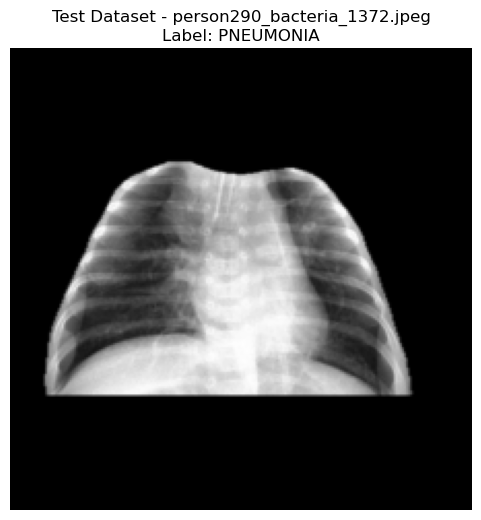

In [8]:
plot_random_image_from_loader(model.test_loader.dataset, "Test Dataset", normalize=False)

# Train Model

In [9]:

# Train Model
model.train_model()
torch.save({
    "state_dict": model.state_dict(),
    "config": config
}, f"../models/{config.model_name}_final.pt")

C:\Users\aszab\miniconda3\envs\pneumonia_detection\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\aszab\Documents\Studium\Modules\ComputerScienceProject\MedicalImaging\pneumonia_detection\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\aszab\miniconda3\envs\pneumonia_detection\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name              | Type                      | Params | Mode 
------------------------------------------------------------------------
0 | accuracy          | BinaryAccuracy            | 0      | train
1 | precision         | BinaryPrecision           | 0      | train
2 | recall            | BinaryRecall              | 0      | train
3 | f1                | BinaryF1Score             | 0      | train
4 | specificity       | BinarySpecificity       

Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:01<00:01,  0.60it/s]

C:\Users\aszab\miniconda3\envs\pneumonia_detection\Lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 0: 100%|██████████| 129/129 [01:00<00:00,  2.13it/s, v_num=0, train_loss_step=0.632]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 129/129 [01:14<00:00,  1.73it/s, v_num=0, train_loss_step=0.632, val_acc_epoch=0.546, val_precision_epoch=0.917, val_recall_epoch=0.416, val_f1_epoch=0.572, val_specificity_epoch=0.898]

C:\Users\aszab\miniconda3\envs\pneumonia_detection\Lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 14. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
Metric val_loss improved. New best score: 0.621


Epoch 1: 100%|██████████| 129/129 [00:59<00:00,  2.18it/s, v_num=0, train_loss_step=0.569, val_acc_epoch=0.546, val_precision_epoch=0.917, val_recall_epoch=0.416, val_f1_epoch=0.572, val_specificity_epoch=0.898]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 129/129 [01:13<00:00,  1.76it/s, v_num=0, train_loss_step=0.569, val_acc_epoch=0.747, val_precision_epoch=0.919, val_recall_epoch=0.717, val_f1_epoch=0.805, val_specificity_epoch=0.829]

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.582


Epoch 2: 100%|██████████| 129/129 [00:58<00:00,  2.20it/s, v_num=0, train_loss_step=0.715, val_acc_epoch=0.747, val_precision_epoch=0.919, val_recall_epoch=0.717, val_f1_epoch=0.805, val_specificity_epoch=0.829]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 129/129 [01:12<00:00,  1.77it/s, v_num=0, train_loss_step=0.715, val_acc_epoch=0.792, val_precision_epoch=0.932, val_recall_epoch=0.771, val_f1_epoch=0.844, val_specificity_epoch=0.848]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.559


Epoch 3: 100%|██████████| 129/129 [00:58<00:00,  2.20it/s, v_num=0, train_loss_step=0.666, val_acc_epoch=0.792, val_precision_epoch=0.932, val_recall_epoch=0.771, val_f1_epoch=0.844, val_specificity_epoch=0.848]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 129/129 [01:12<00:00,  1.77it/s, v_num=0, train_loss_step=0.666, val_acc_epoch=0.803, val_precision_epoch=0.944, val_recall_epoch=0.777, val_f1_epoch=0.852, val_specificity_epoch=0.875]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.533


Epoch 4: 100%|██████████| 129/129 [00:58<00:00,  2.20it/s, v_num=0, train_loss_step=0.563, val_acc_epoch=0.803, val_precision_epoch=0.944, val_recall_epoch=0.777, val_f1_epoch=0.852, val_specificity_epoch=0.875]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 129/129 [01:12<00:00,  1.78it/s, v_num=0, train_loss_step=0.563, val_acc_epoch=0.812, val_precision_epoch=0.944, val_recall_epoch=0.790, val_f1_epoch=0.860, val_specificity_epoch=0.873]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.510


Epoch 5: 100%|██████████| 129/129 [00:59<00:00,  2.18it/s, v_num=0, train_loss_step=0.536, val_acc_epoch=0.812, val_precision_epoch=0.944, val_recall_epoch=0.790, val_f1_epoch=0.860, val_specificity_epoch=0.873]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 129/129 [01:13<00:00,  1.76it/s, v_num=0, train_loss_step=0.536, val_acc_epoch=0.820, val_precision_epoch=0.945, val_recall_epoch=0.799, val_f1_epoch=0.866, val_specificity_epoch=0.874]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.491


Epoch 6: 100%|██████████| 129/129 [00:58<00:00,  2.21it/s, v_num=0, train_loss_step=0.881, val_acc_epoch=0.820, val_precision_epoch=0.945, val_recall_epoch=0.799, val_f1_epoch=0.866, val_specificity_epoch=0.874]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 129/129 [01:12<00:00,  1.78it/s, v_num=0, train_loss_step=0.881, val_acc_epoch=0.826, val_precision_epoch=0.948, val_recall_epoch=0.806, val_f1_epoch=0.871, val_specificity_epoch=0.882]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.477


Epoch 7: 100%|██████████| 129/129 [00:58<00:00,  2.21it/s, v_num=0, train_loss_step=0.378, val_acc_epoch=0.826, val_precision_epoch=0.948, val_recall_epoch=0.806, val_f1_epoch=0.871, val_specificity_epoch=0.882]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 129/129 [01:12<00:00,  1.78it/s, v_num=0, train_loss_step=0.378, val_acc_epoch=0.834, val_precision_epoch=0.953, val_recall_epoch=0.812, val_f1_epoch=0.877, val_specificity_epoch=0.893]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.459


Epoch 8: 100%|██████████| 129/129 [00:58<00:00,  2.20it/s, v_num=0, train_loss_step=0.369, val_acc_epoch=0.834, val_precision_epoch=0.953, val_recall_epoch=0.812, val_f1_epoch=0.877, val_specificity_epoch=0.893]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 129/129 [01:12<00:00,  1.77it/s, v_num=0, train_loss_step=0.369, val_acc_epoch=0.834, val_precision_epoch=0.951, val_recall_epoch=0.815, val_f1_epoch=0.878, val_specificity_epoch=0.887]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.444


Epoch 9: 100%|██████████| 129/129 [00:58<00:00,  2.20it/s, v_num=0, train_loss_step=0.245, val_acc_epoch=0.834, val_precision_epoch=0.951, val_recall_epoch=0.815, val_f1_epoch=0.878, val_specificity_epoch=0.887]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 129/129 [01:12<00:00,  1.78it/s, v_num=0, train_loss_step=0.245, val_acc_epoch=0.840, val_precision_epoch=0.949, val_recall_epoch=0.825, val_f1_epoch=0.883, val_specificity_epoch=0.880]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.433


Epoch 10: 100%|██████████| 129/129 [00:57<00:00,  2.23it/s, v_num=0, train_loss_step=0.679, val_acc_epoch=0.840, val_precision_epoch=0.949, val_recall_epoch=0.825, val_f1_epoch=0.883, val_specificity_epoch=0.880]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 129/129 [01:12<00:00,  1.79it/s, v_num=0, train_loss_step=0.679, val_acc_epoch=0.840, val_precision_epoch=0.953, val_recall_epoch=0.822, val_f1_epoch=0.882, val_specificity_epoch=0.890]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.421


Epoch 11: 100%|██████████| 129/129 [00:58<00:00,  2.20it/s, v_num=0, train_loss_step=0.732, val_acc_epoch=0.840, val_precision_epoch=0.953, val_recall_epoch=0.822, val_f1_epoch=0.882, val_specificity_epoch=0.890]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 129/129 [01:12<00:00,  1.77it/s, v_num=0, train_loss_step=0.732, val_acc_epoch=0.842, val_precision_epoch=0.951, val_recall_epoch=0.826, val_f1_epoch=0.884, val_specificity_epoch=0.886]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.412


Epoch 12: 100%|██████████| 129/129 [00:58<00:00,  2.21it/s, v_num=0, train_loss_step=0.285, val_acc_epoch=0.842, val_precision_epoch=0.951, val_recall_epoch=0.826, val_f1_epoch=0.884, val_specificity_epoch=0.886]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 129/129 [01:12<00:00,  1.78it/s, v_num=0, train_loss_step=0.285, val_acc_epoch=0.844, val_precision_epoch=0.957, val_recall_epoch=0.824, val_f1_epoch=0.885, val_specificity_epoch=0.899]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.407


Epoch 13: 100%|██████████| 129/129 [00:58<00:00,  2.19it/s, v_num=0, train_loss_step=0.258, val_acc_epoch=0.844, val_precision_epoch=0.957, val_recall_epoch=0.824, val_f1_epoch=0.885, val_specificity_epoch=0.899]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 129/129 [01:13<00:00,  1.76it/s, v_num=0, train_loss_step=0.258, val_acc_epoch=0.847, val_precision_epoch=0.958, val_recall_epoch=0.826, val_f1_epoch=0.887, val_specificity_epoch=0.903]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.395


Epoch 14: 100%|██████████| 129/129 [00:58<00:00,  2.20it/s, v_num=0, train_loss_step=0.348, val_acc_epoch=0.847, val_precision_epoch=0.958, val_recall_epoch=0.826, val_f1_epoch=0.887, val_specificity_epoch=0.903]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 129/129 [01:12<00:00,  1.78it/s, v_num=0, train_loss_step=0.348, val_acc_epoch=0.851, val_precision_epoch=0.956, val_recall_epoch=0.834, val_f1_epoch=0.891, val_specificity_epoch=0.895]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.383


Epoch 15: 100%|██████████| 129/129 [00:59<00:00,  2.18it/s, v_num=0, train_loss_step=0.194, val_acc_epoch=0.851, val_precision_epoch=0.956, val_recall_epoch=0.834, val_f1_epoch=0.891, val_specificity_epoch=0.895]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 129/129 [01:13<00:00,  1.76it/s, v_num=0, train_loss_step=0.194, val_acc_epoch=0.856, val_precision_epoch=0.957, val_recall_epoch=0.841, val_f1_epoch=0.895, val_specificity_epoch=0.897]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.379


Epoch 16: 100%|██████████| 129/129 [00:58<00:00,  2.21it/s, v_num=0, train_loss_step=0.251, val_acc_epoch=0.856, val_precision_epoch=0.957, val_recall_epoch=0.841, val_f1_epoch=0.895, val_specificity_epoch=0.897]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 129/129 [01:12<00:00,  1.77it/s, v_num=0, train_loss_step=0.251, val_acc_epoch=0.852, val_precision_epoch=0.956, val_recall_epoch=0.835, val_f1_epoch=0.892, val_specificity_epoch=0.897]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.369


Epoch 17: 100%|██████████| 129/129 [00:59<00:00,  2.17it/s, v_num=0, train_loss_step=0.696, val_acc_epoch=0.852, val_precision_epoch=0.956, val_recall_epoch=0.835, val_f1_epoch=0.892, val_specificity_epoch=0.897]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 129/129 [00:58<00:00,  2.21it/s, v_num=0, train_loss_step=0.357, val_acc_epoch=0.857, val_precision_epoch=0.954, val_recall_epoch=0.844, val_f1_epoch=0.896, val_specificity_epoch=0.890]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 129/129 [01:12<00:00,  1.78it/s, v_num=0, train_loss_step=0.357, val_acc_epoch=0.855, val_precision_epoch=0.955, val_recall_epoch=0.840, val_f1_epoch=0.894, val_specificity_epoch=0.894]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.368


Epoch 19: 100%|██████████| 129/129 [00:59<00:00,  2.18it/s, v_num=0, train_loss_step=0.321, val_acc_epoch=0.855, val_precision_epoch=0.955, val_recall_epoch=0.840, val_f1_epoch=0.894, val_specificity_epoch=0.894]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 129/129 [01:13<00:00,  1.76it/s, v_num=0, train_loss_step=0.321, val_acc_epoch=0.856, val_precision_epoch=0.957, val_recall_epoch=0.840, val_f1_epoch=0.895, val_specificity_epoch=0.897]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.362


Epoch 20: 100%|██████████| 129/129 [00:57<00:00,  2.23it/s, v_num=0, train_loss_step=0.281, val_acc_epoch=0.856, val_precision_epoch=0.957, val_recall_epoch=0.840, val_f1_epoch=0.895, val_specificity_epoch=0.897]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 20: 100%|██████████| 129/129 [01:12<00:00,  1.79it/s, v_num=0, train_loss_step=0.281, val_acc_epoch=0.862, val_precision_epoch=0.961, val_recall_epoch=0.845, val_f1_epoch=0.899, val_specificity_epoch=0.907]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.352


Epoch 21: 100%|██████████| 129/129 [00:58<00:00,  2.20it/s, v_num=0, train_loss_step=0.104, val_acc_epoch=0.862, val_precision_epoch=0.961, val_recall_epoch=0.845, val_f1_epoch=0.899, val_specificity_epoch=0.907]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 21: 100%|██████████| 129/129 [01:13<00:00,  1.76it/s, v_num=0, train_loss_step=0.104, val_acc_epoch=0.863, val_precision_epoch=0.956, val_recall_epoch=0.851, val_f1_epoch=0.901, val_specificity_epoch=0.894]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.350


Epoch 22: 100%|██████████| 129/129 [00:58<00:00,  2.19it/s, v_num=0, train_loss_step=0.213, val_acc_epoch=0.863, val_precision_epoch=0.956, val_recall_epoch=0.851, val_f1_epoch=0.901, val_specificity_epoch=0.894]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 22: 100%|██████████| 129/129 [01:12<00:00,  1.77it/s, v_num=0, train_loss_step=0.213, val_acc_epoch=0.857, val_precision_epoch=0.959, val_recall_epoch=0.841, val_f1_epoch=0.896, val_specificity_epoch=0.903]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.346


Epoch 23: 100%|██████████| 129/129 [00:58<00:00,  2.19it/s, v_num=0, train_loss_step=0.181, val_acc_epoch=0.857, val_precision_epoch=0.959, val_recall_epoch=0.841, val_f1_epoch=0.896, val_specificity_epoch=0.903]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 23: 100%|██████████| 129/129 [01:12<00:00,  1.77it/s, v_num=0, train_loss_step=0.181, val_acc_epoch=0.863, val_precision_epoch=0.958, val_recall_epoch=0.849, val_f1_epoch=0.900, val_specificity_epoch=0.899]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.340


Epoch 24: 100%|██████████| 129/129 [00:58<00:00,  2.20it/s, v_num=0, train_loss_step=0.121, val_acc_epoch=0.863, val_precision_epoch=0.958, val_recall_epoch=0.849, val_f1_epoch=0.900, val_specificity_epoch=0.899]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 24: 100%|██████████| 129/129 [01:12<00:00,  1.78it/s, v_num=0, train_loss_step=0.121, val_acc_epoch=0.863, val_precision_epoch=0.958, val_recall_epoch=0.849, val_f1_epoch=0.900, val_specificity_epoch=0.899]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.339


Epoch 25: 100%|██████████| 129/129 [00:59<00:00,  2.18it/s, v_num=0, train_loss_step=0.741, val_acc_epoch=0.863, val_precision_epoch=0.958, val_recall_epoch=0.849, val_f1_epoch=0.900, val_specificity_epoch=0.899]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 25: 100%|██████████| 129/129 [01:13<00:00,  1.77it/s, v_num=0, train_loss_step=0.741, val_acc_epoch=0.862, val_precision_epoch=0.960, val_recall_epoch=0.846, val_f1_epoch=0.899, val_specificity_epoch=0.905]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.337


Epoch 26: 100%|██████████| 129/129 [00:57<00:00,  2.24it/s, v_num=0, train_loss_step=0.427, val_acc_epoch=0.862, val_precision_epoch=0.960, val_recall_epoch=0.846, val_f1_epoch=0.899, val_specificity_epoch=0.905]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 26: 100%|██████████| 129/129 [01:11<00:00,  1.81it/s, v_num=0, train_loss_step=0.427, val_acc_epoch=0.864, val_precision_epoch=0.960, val_recall_epoch=0.849, val_f1_epoch=0.901, val_specificity_epoch=0.905]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.328


Epoch 27: 100%|██████████| 129/129 [00:57<00:00,  2.25it/s, v_num=0, train_loss_step=0.503, val_acc_epoch=0.864, val_precision_epoch=0.960, val_recall_epoch=0.849, val_f1_epoch=0.901, val_specificity_epoch=0.905]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 27: 100%|██████████| 129/129 [01:11<00:00,  1.82it/s, v_num=0, train_loss_step=0.503, val_acc_epoch=0.867, val_precision_epoch=0.960, val_recall_epoch=0.853, val_f1_epoch=0.903, val_specificity_epoch=0.903]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.327


Epoch 28: 100%|██████████| 129/129 [00:57<00:00,  2.23it/s, v_num=0, train_loss_step=0.341, val_acc_epoch=0.867, val_precision_epoch=0.960, val_recall_epoch=0.853, val_f1_epoch=0.903, val_specificity_epoch=0.903]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 28: 100%|██████████| 129/129 [01:12<00:00,  1.79it/s, v_num=0, train_loss_step=0.341, val_acc_epoch=0.871, val_precision_epoch=0.959, val_recall_epoch=0.860, val_f1_epoch=0.907, val_specificity_epoch=0.902]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.325


Epoch 29: 100%|██████████| 129/129 [00:58<00:00,  2.21it/s, v_num=0, train_loss_step=0.575, val_acc_epoch=0.871, val_precision_epoch=0.959, val_recall_epoch=0.860, val_f1_epoch=0.907, val_specificity_epoch=0.902]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 29: 100%|██████████| 129/129 [01:12<00:00,  1.78it/s, v_num=0, train_loss_step=0.575, val_acc_epoch=0.867, val_precision_epoch=0.958, val_recall_epoch=0.855, val_f1_epoch=0.904, val_specificity_epoch=0.899]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.324


Epoch 30: 100%|██████████| 129/129 [00:57<00:00,  2.23it/s, v_num=0, train_loss_step=0.122, val_acc_epoch=0.867, val_precision_epoch=0.958, val_recall_epoch=0.855, val_f1_epoch=0.904, val_specificity_epoch=0.899]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 30: 100%|██████████| 129/129 [01:11<00:00,  1.80it/s, v_num=0, train_loss_step=0.122, val_acc_epoch=0.870, val_precision_epoch=0.960, val_recall_epoch=0.858, val_f1_epoch=0.906, val_specificity_epoch=0.903]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.321


Epoch 31: 100%|██████████| 129/129 [00:58<00:00,  2.22it/s, v_num=0, train_loss_step=0.139, val_acc_epoch=0.870, val_precision_epoch=0.960, val_recall_epoch=0.858, val_f1_epoch=0.906, val_specificity_epoch=0.903]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 31: 100%|██████████| 129/129 [01:12<00:00,  1.79it/s, v_num=0, train_loss_step=0.139, val_acc_epoch=0.864, val_precision_epoch=0.959, val_recall_epoch=0.850, val_f1_epoch=0.901, val_specificity_epoch=0.903]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.314


Epoch 32: 100%|██████████| 129/129 [00:57<00:00,  2.23it/s, v_num=0, train_loss_step=0.411, val_acc_epoch=0.864, val_precision_epoch=0.959, val_recall_epoch=0.850, val_f1_epoch=0.901, val_specificity_epoch=0.903]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 32: 100%|██████████| 129/129 [01:11<00:00,  1.80it/s, v_num=0, train_loss_step=0.411, val_acc_epoch=0.871, val_precision_epoch=0.959, val_recall_epoch=0.860, val_f1_epoch=0.907, val_specificity_epoch=0.900]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.314


Epoch 33: 100%|██████████| 129/129 [00:58<00:00,  2.20it/s, v_num=0, train_loss_step=0.106, val_acc_epoch=0.871, val_precision_epoch=0.959, val_recall_epoch=0.860, val_f1_epoch=0.907, val_specificity_epoch=0.900]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 33: 100%|██████████| 129/129 [01:12<00:00,  1.79it/s, v_num=0, train_loss_step=0.106, val_acc_epoch=0.872, val_precision_epoch=0.960, val_recall_epoch=0.861, val_f1_epoch=0.908, val_specificity_epoch=0.903]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.312


Epoch 34: 100%|██████████| 129/129 [00:57<00:00,  2.24it/s, v_num=0, train_loss_step=0.0457, val_acc_epoch=0.872, val_precision_epoch=0.960, val_recall_epoch=0.861, val_f1_epoch=0.908, val_specificity_epoch=0.903]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 34: 100%|██████████| 129/129 [01:11<00:00,  1.81it/s, v_num=0, train_loss_step=0.0457, val_acc_epoch=0.871, val_precision_epoch=0.960, val_recall_epoch=0.859, val_f1_epoch=0.907, val_specificity_epoch=0.903]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.311


Epoch 35: 100%|██████████| 129/129 [00:58<00:00,  2.22it/s, v_num=0, train_loss_step=0.0736, val_acc_epoch=0.871, val_precision_epoch=0.960, val_recall_epoch=0.859, val_f1_epoch=0.907, val_specificity_epoch=0.903]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 35: 100%|██████████| 129/129 [01:11<00:00,  1.80it/s, v_num=0, train_loss_step=0.0736, val_acc_epoch=0.872, val_precision_epoch=0.959, val_recall_epoch=0.862, val_f1_epoch=0.907, val_specificity_epoch=0.900]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.310


Epoch 36: 100%|██████████| 129/129 [00:58<00:00,  2.21it/s, v_num=0, train_loss_step=0.284, val_acc_epoch=0.872, val_precision_epoch=0.959, val_recall_epoch=0.862, val_f1_epoch=0.907, val_specificity_epoch=0.900]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 36: 100%|██████████| 129/129 [01:12<00:00,  1.79it/s, v_num=0, train_loss_step=0.284, val_acc_epoch=0.870, val_precision_epoch=0.962, val_recall_epoch=0.856, val_f1_epoch=0.906, val_specificity_epoch=0.909]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.309


Epoch 37: 100%|██████████| 129/129 [00:58<00:00,  2.21it/s, v_num=0, train_loss_step=0.264, val_acc_epoch=0.870, val_precision_epoch=0.962, val_recall_epoch=0.856, val_f1_epoch=0.906, val_specificity_epoch=0.909]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 37: 100%|██████████| 129/129 [01:12<00:00,  1.79it/s, v_num=0, train_loss_step=0.264, val_acc_epoch=0.877, val_precision_epoch=0.963, val_recall_epoch=0.864, val_f1_epoch=0.911, val_specificity_epoch=0.912]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.305


Epoch 38: 100%|██████████| 129/129 [00:57<00:00,  2.23it/s, v_num=0, train_loss_step=0.0344, val_acc_epoch=0.877, val_precision_epoch=0.963, val_recall_epoch=0.864, val_f1_epoch=0.911, val_specificity_epoch=0.912]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 38: 100%|██████████| 129/129 [01:11<00:00,  1.80it/s, v_num=0, train_loss_step=0.0344, val_acc_epoch=0.875, val_precision_epoch=0.959, val_recall_epoch=0.866, val_f1_epoch=0.910, val_specificity_epoch=0.900]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.301


Epoch 39: 100%|██████████| 129/129 [00:58<00:00,  2.21it/s, v_num=0, train_loss_step=0.314, val_acc_epoch=0.875, val_precision_epoch=0.959, val_recall_epoch=0.866, val_f1_epoch=0.910, val_specificity_epoch=0.900]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 40: 100%|██████████| 129/129 [00:57<00:00,  2.26it/s, v_num=0, train_loss_step=0.291, val_acc_epoch=0.873, val_precision_epoch=0.957, val_recall_epoch=0.865, val_f1_epoch=0.909, val_specificity_epoch=0.895]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 40: 100%|██████████| 129/129 [01:10<00:00,  1.82it/s, v_num=0, train_loss_step=0.291, val_acc_epoch=0.875, val_precision_epoch=0.961, val_recall_epoch=0.865, val_f1_epoch=0.910, val_specificity_epoch=0.904]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.298


Epoch 41: 100%|██████████| 129/129 [00:56<00:00,  2.26it/s, v_num=0, train_loss_step=0.0945, val_acc_epoch=0.875, val_precision_epoch=0.961, val_recall_epoch=0.865, val_f1_epoch=0.910, val_specificity_epoch=0.904]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 41: 100%|██████████| 129/129 [01:10<00:00,  1.82it/s, v_num=0, train_loss_step=0.0945, val_acc_epoch=0.877, val_precision_epoch=0.962, val_recall_epoch=0.865, val_f1_epoch=0.911, val_specificity_epoch=0.907]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.295


Epoch 42: 100%|██████████| 129/129 [00:57<00:00,  2.24it/s, v_num=0, train_loss_step=0.064, val_acc_epoch=0.877, val_precision_epoch=0.962, val_recall_epoch=0.865, val_f1_epoch=0.911, val_specificity_epoch=0.907]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 43: 100%|██████████| 129/129 [00:58<00:00,  2.22it/s, v_num=0, train_loss_step=0.466, val_acc_epoch=0.883, val_precision_epoch=0.963, val_recall_epoch=0.873, val_f1_epoch=0.916, val_specificity_epoch=0.909]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 43: 100%|██████████| 129/129 [01:11<00:00,  1.80it/s, v_num=0, train_loss_step=0.466, val_acc_epoch=0.878, val_precision_epoch=0.963, val_recall_epoch=0.866, val_f1_epoch=0.912, val_specificity_epoch=0.909]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.294


Epoch 44: 100%|██████████| 129/129 [00:58<00:00,  2.22it/s, v_num=0, train_loss_step=0.746, val_acc_epoch=0.878, val_precision_epoch=0.963, val_recall_epoch=0.866, val_f1_epoch=0.912, val_specificity_epoch=0.909]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 44: 100%|██████████| 129/129 [01:12<00:00,  1.79it/s, v_num=0, train_loss_step=0.746, val_acc_epoch=0.877, val_precision_epoch=0.963, val_recall_epoch=0.866, val_f1_epoch=0.912, val_specificity_epoch=0.909]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.293


Epoch 45: 100%|██████████| 129/129 [00:58<00:00,  2.22it/s, v_num=0, train_loss_step=0.140, val_acc_epoch=0.877, val_precision_epoch=0.963, val_recall_epoch=0.866, val_f1_epoch=0.912, val_specificity_epoch=0.909]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 46: 100%|██████████| 129/129 [00:58<00:00,  2.21it/s, v_num=0, train_loss_step=0.208, val_acc_epoch=0.879, val_precision_epoch=0.960, val_recall_epoch=0.871, val_f1_epoch=0.913, val_specificity_epoch=0.902]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 46: 100%|██████████| 129/129 [01:12<00:00,  1.79it/s, v_num=0, train_loss_step=0.208, val_acc_epoch=0.878, val_precision_epoch=0.964, val_recall_epoch=0.866, val_f1_epoch=0.912, val_specificity_epoch=0.912]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.290


Epoch 47: 100%|██████████| 129/129 [00:58<00:00,  2.21it/s, v_num=0, train_loss_step=0.106, val_acc_epoch=0.878, val_precision_epoch=0.964, val_recall_epoch=0.866, val_f1_epoch=0.912, val_specificity_epoch=0.912]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 48: 100%|██████████| 129/129 [00:57<00:00,  2.22it/s, v_num=0, train_loss_step=0.144, val_acc_epoch=0.880, val_precision_epoch=0.963, val_recall_epoch=0.870, val_f1_epoch=0.914, val_specificity_epoch=0.909]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 48: 100%|██████████| 129/129 [01:11<00:00,  1.80it/s, v_num=0, train_loss_step=0.144, val_acc_epoch=0.880, val_precision_epoch=0.961, val_recall_epoch=0.871, val_f1_epoch=0.914, val_specificity_epoch=0.904]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.286


Epoch 49: 100%|██████████| 129/129 [00:58<00:00,  2.21it/s, v_num=0, train_loss_step=0.300, val_acc_epoch=0.880, val_precision_epoch=0.961, val_recall_epoch=0.871, val_f1_epoch=0.914, val_specificity_epoch=0.904]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 129/129 [01:12<00:00,  1.78it/s, v_num=0, train_loss_step=0.300, val_acc_epoch=0.884, val_precision_epoch=0.962, val_recall_epoch=0.875, val_f1_epoch=0.917, val_specificity_epoch=0.908]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.286
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 129/129 [01:14<00:00,  1.73it/s, v_num=0, train_loss_step=0.300, val_acc_epoch=0.884, val_precision_epoch=0.962, val_recall_epoch=0.875, val_f1_epoch=0.917, val_specificity_epoch=0.908]


# Load Model

In [10]:

checkpoint = torch.load(f"../models/{config.model_name}_final.pt")
loaded_config = checkpoint["config"]
model = ViTPneumoniaClassifier(loaded_config)
model.load_state_dict(checkpoint["state_dict"])
model.eval()
model = model.to(device)

C:\Users\aszab\AppData\Local\Temp\ipykernel_5984\3319896268.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"../models/{config.model_name}_final

# Test Model

In [11]:
# Run testing
print("Testing the model...")
checkpoint_path = f"../checkpoints/{config.model_name}.ckpt"
test_metadata = model.test_model(checkpoint_path)  # Ensure this uses the correct test_loader

Testing the model...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 28/28 [00:11<00:00,  2.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.8930602669715881
      test_f1_epoch         0.9221854209899902
  test_precision_epoch      0.9823633432388306
    test_recall_epoch       0.8689547777175903
 test_specificity_epoch     0.9579831957817078
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


# Plot Confusion Matrix

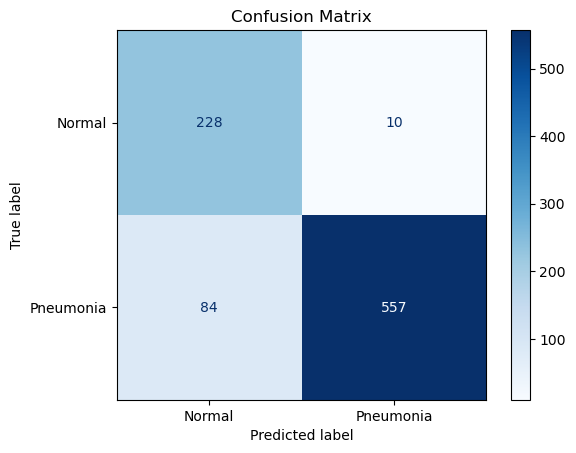

In [12]:
def plot_confusion_matrix(model, dataloader, class_names):
    all_preds = []
    all_labels = []

    # Get predictions and true labels
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for data, labels, _ in dataloader:
            data = data.cuda()  # Move data to GPU if available
            labels = labels.cuda()
            preds = torch.argmax(model(data), dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

# Call this after training/testing
plot_confusion_matrix(model, model.test_loader, class_names=["Normal", "Pneumonia"])

# Plot ROC/AUC Score

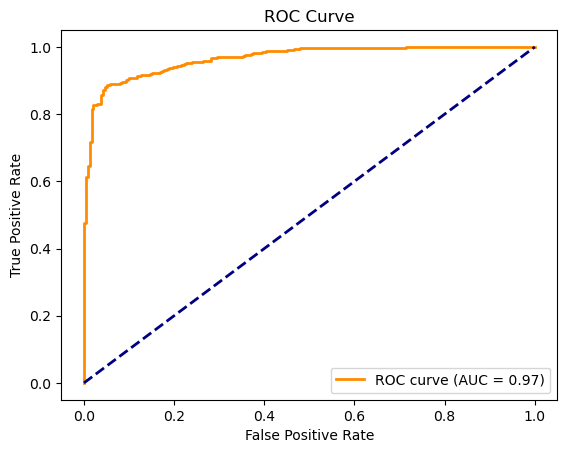

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_auc(model, dataloader):
    all_preds = []
    all_labels = []

    # Get predictions and true labels
    model.eval()
    with torch.no_grad():
        for data, labels, _ in dataloader:
            data = data.cuda()
            labels = labels.cuda()
            preds = model(data)
            probs = torch.softmax(preds, dim=1)[:, 1]  # Probabilities for class 1
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_preds)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_auc(model, model.test_loader)

# Plot Gradcam

In [14]:
for param in model.feature_extractor.parameters():
    param.requires_grad = True

model.visualize_gradcam(
    num_samples=4,
    target_layer=9,  # Default to the last layer
    class_names=["Normal", "Pneumonia"],
    threshold=0.6
)


TypeError: ViTPneumoniaClassifier.visualize_gradcam() got an unexpected keyword argument 'num_samples'

# Evaluate Metrics in Tensorboard

In [15]:
# Load TensorBoard extension
%load_ext tensorboard

# Specify the log directory
log_dir = f"tb_logs/{config.model_name}"

# Start TensorBoard
%tensorboard --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Classify random images

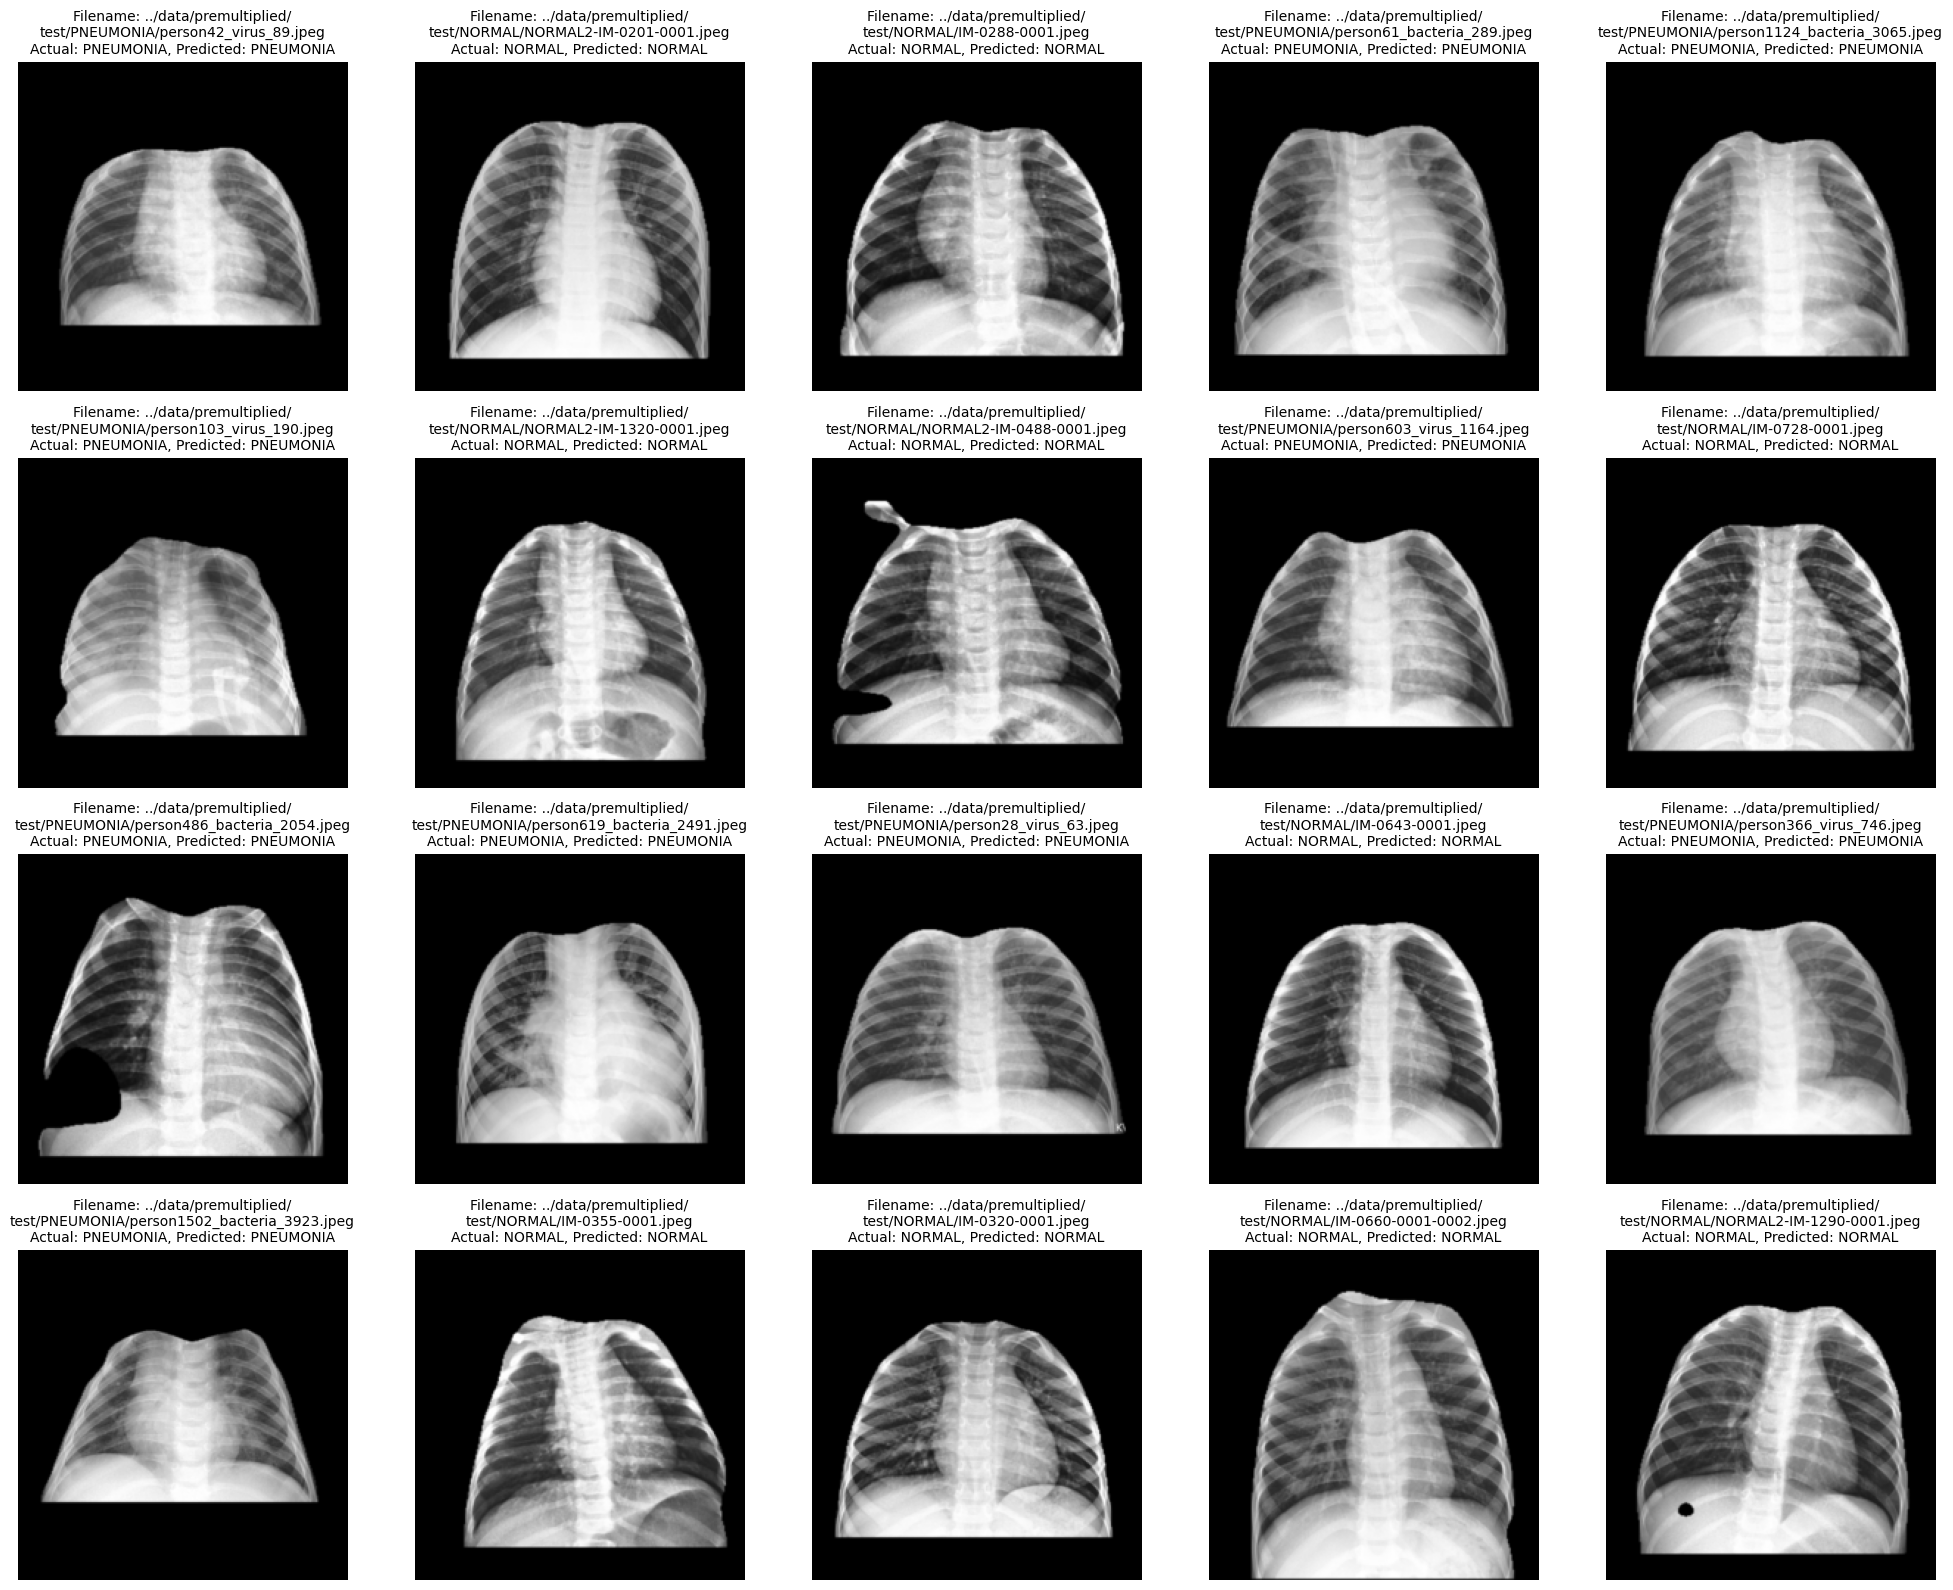

In [16]:
plot_random_images_with_labels(model, model.test_loader, num_images=20)